#  <span style='color:midnightblue'>  Clustering Mixed Data Types


Clustering data of mixed types (e.g., continuous, ordinal, and nominal)

##  <span style='color:royalblue'>  1. Load required libraries </span>

In [1]:
library(dplyr)
library(ISLR) 
library(cluster)
library(Rtsne) 
library(ggplot2)
library(skimr)

Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


##  <span style='color:royalblue'>  2. Load dataset </span>
The college dataset is included in the ISLR package. It contains statistics for a large number of US Colleges from the 1995 issue of US News and World Report.

In [2]:
head(College,5)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [3]:
skim(College)

── Data Summary ────────────────────────
                           Values 
Name                       College
Number of rows             777    
Number of columns          18     
_______________________           
Column type frequency:            
  factor                   1      
  numeric                  17     
________________________          
Group variables            None   

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts       
1 Private               0             1 FALSE          2 Yes: 565, No: 212

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate    mean      sd     p0    p25    p50
 1 Apps                  0             1  3002.  3870.     81    776   1558  
 2 Accept                0             1  2019.  2451.     72    604   1110  
 3 Enroll                0             1   780.   929.     35

To highlight the challenge of handling mixed data types, variables that are both categorical and continuous will be used and are listed below:

- **Continuous**
    - Acceptance rate
    - Out of school tuition
    - Number of new students enrolled
    
- **Categorical**
    - Whether a college is public/private
    - Whether a college is elite, defined as having more than 50% of new students who graduated in the top 10% of their high school class

##  <span style='color:royalblue'>  3. Data preparation </span>
- Acceptance rate is created by diving the number of acceptances by the number of applications
- isElite is created by labeling colleges with more than 50% of their new students who were in the top 10% of their high school class as elite

In [4]:
college_clean <- College %>%
  mutate(name = row.names(.),
         accept_rate = Accept/Apps,
         isElite = cut(Top10perc,
                       breaks = c(0, 50, 100),
                       labels = c("Not Elite", "Elite"),
                       include.lowest = TRUE)) %>%
  mutate(isElite = factor(isElite)) %>%
  select(name, accept_rate, Outstate, Enroll,
         Grad.Rate, Private, isElite)

head(college_clean,5)

name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
Abilene Christian University,0.7421687,7440,721,60,Yes,Not Elite
Adelphi University,0.8801464,12280,512,56,Yes,Not Elite
Adrian College,0.7682073,11250,336,54,Yes,Not Elite
Agnes Scott College,0.8369305,12960,137,59,Yes,Elite
Alaska Pacific University,0.7564767,7560,55,15,Yes,Not Elite


##  <span style='color:royalblue'>  4. Calculating distances </span>

- Euclidean distance is only valid for continuous variables, and thus is not applicable here. 
- Gower algorithm use a distance metric that can handle mixed data types. 

###  <span style='color:royalblue'>  4.1. Gower algorithm </span>

1. For each variable type, a particular distance metric that works well for that type is used and scaled to fall between 0 and 1
    - quantitative (interval): range-normalized Manhattan distance
    - ordinal: variable is first ranked, then Manhattan distance is used with a special adjustment for ties
    - nominal: variables of k categories are first converted into k binary columns and then the Dice coefficient is used
2. Finally a linear combination using user-specified weights (most simply an average) is calculated to create the final distance matrix.

In [5]:
gower_dist <- daisy(college_clean[, -1], # Remove college name from the clustering algorithm
                    metric = "gower",
                    type = list(logratio = 3))
gower_mat <- as.matrix(gower_dist)

###  <span style='color:royalblue'>  4.2. Check most similar and dissimilar pairs

In [6]:
# Most similar pair
college_clean[
  which(gower_mat == min(gower_mat[gower_mat != min(gower_mat)]),
        arr.ind = TRUE)[1, ], ]

,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
682,University of St. Thomas MN,0.8784638,11712,828,89,Yes,Not Elite
284,John Carroll University,0.8711276,11700,820,89,Yes,Not Elite


In [7]:
# Most dissimilar pair
college_clean[
  which(gower_mat == max(gower_mat[gower_mat != max(gower_mat)]),
        arr.ind = TRUE)[1, ], ]

,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
673,University of Sci. and Arts of Oklahoma,0.9824561,3687,208,43,No,Not Elite
251,Harvard University,0.1561486,18485,1606,100,Yes,Elite


##  <span style='color:royalblue'>  6. Clustering using PAM algorithm (partitioning around medoids)  </span>
k-means has cluster centers defined by Euclidean distance (i.e., centroids), while cluster centers for PAM are restricted to be the observations themselves (i.e., medoids).


###  <span style='color:royalblue'>  6.1. Selecting number of clusters with silhouette width method
Optimal number of clusters: 3

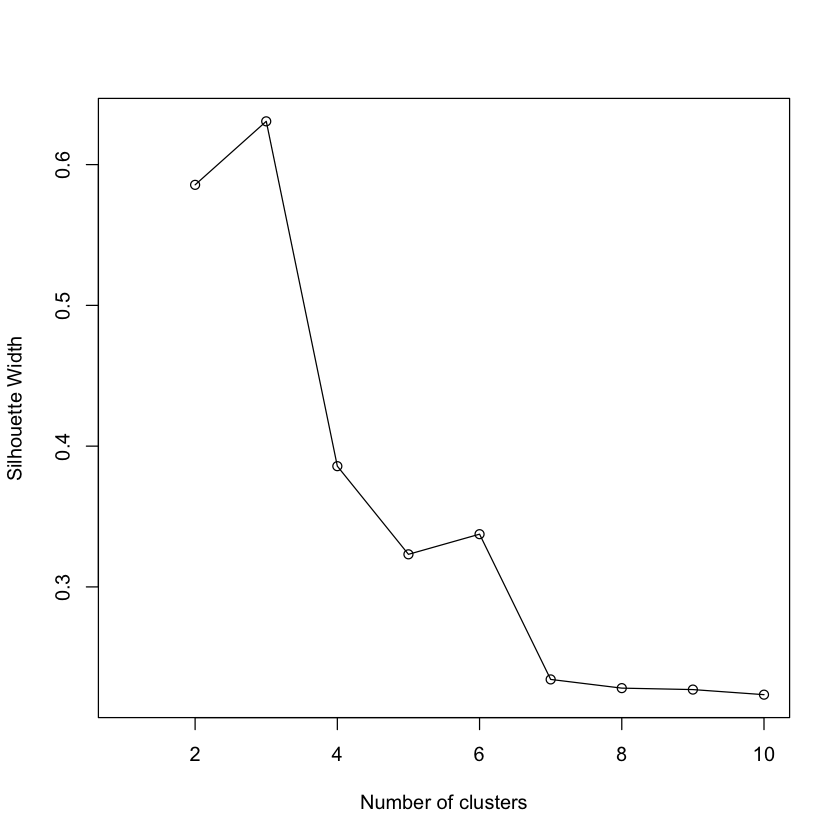

In [8]:
sil_width <- c(NA)

for(i in 2:10){
  
  pam_fit <- pam(gower_dist,
                 diss = TRUE,
                 k = i)
  
  sil_width[i] <- pam_fit$silinfo$avg.width
  
}

plot(1:10, sil_width,
     xlab = "Number of clusters",
     ylab = "Silhouette Width")
lines(1:10, sil_width)

###  <span style='color:royalblue'>  6.2. Deploying clustering algorithm

In [57]:
pam_fit <- pam(gower_dist, diss = TRUE, k = 3)

In [45]:
dd <- cbind(college_clean, cluster = pam_fit$cluster)
dd <- dd[order(dd$cluster, dd$accept_rate),]

In [49]:
#Top 10 universities in Cluster 1 by acceptance rate
top_c1 <- dd[dd$cluster == 1, ]
head(top_c1,10)

,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite,cluster
265,Huron University,0.3283333,7260,124,21,Yes,Not Elite,1
543,Spelman College,0.3331538,7000,443,65,Yes,Not Elite,1
579,Talladega College,0.3398278,5666,335,46,Yes,Not Elite,1
78,California Lutheran University,0.4387211,12950,247,60,Yes,Not Elite,1
37,Bard College,0.4387435,19264,285,79,Yes,Not Elite,1
388,Morehouse College,0.4525351,7050,722,83,Yes,Not Elite,1
441,Pace University,0.4542151,11000,1522,62,Yes,Not Elite,1
669,University of Richmond,0.4613035,14500,756,100,Yes,Not Elite,1
25,Arkansas College (Lyon College),0.4717514,8644,166,54,Yes,Not Elite,1
602,Union College NY,0.4898426,18732,528,88,Yes,Not Elite,1


In [50]:
#Top 10 universities in Cluster 2 by acceptance rate
top_c2 <- dd[dd$cluster == 2, ]
head(top_c2,10)

,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite,cluster
460,Princeton University,0.1544863,19900,1153,99,Yes,Elite,2
251,Harvard University,0.1561486,18485,1606,100,Yes,Elite,2
776,Yale University,0.2291453,19840,1317,99,Yes,Elite,2
17,Amherst College,0.2305904,19760,418,100,Yes,Elite,2
71,Brown University,0.2573494,19528,1462,97,Yes,Elite,2
222,Georgetown University,0.2591993,18300,1390,95,Yes,Elite,2
159,Dartmouth College,0.2647025,19545,1087,98,Yes,Elite,2
175,Duke University,0.2823265,18590,1583,97,Yes,Elite,2
145,Columbia University,0.2856720,18624,871,99,Yes,Elite,2
764,Williams College,0.2974200,19629,526,99,Yes,Elite,2


In [51]:
#Top 10 universities in Cluster 3 by acceptance rate
top_c3 <- dd[dd$cluster == 3, ]
head(top_c3,10)

,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite,cluster
483,Rowan College of New Jersey,0.3746073,4356,695,51,No,Not Elite,3
559,Stockton College of New Jersey,0.3928838,3040,710,64,No,Not Elite,3
384,Montclair State University,0.4076628,3648,865,58,No,Not Elite,3
652,University of North Carolina at Chapel Hill,0.4100438,8400,3331,83,No,Elite,3
608,University of Central Florida,0.4235614,6618,1918,46,No,Not Elite,3
562,SUNY at Binghamton,0.4263293,6550,1757,80,No,Elite,3
571,SUNY College at New Paltz,0.4296940,6550,656,53,No,Not Elite,3
568,SUNY College at Cortland,0.4461207,6550,1036,53,No,Not Elite,3
57,Bloomsburg Univ. of Pennsylvania,0.4470692,7844,1025,75,No,Not Elite,3
467,Ramapo College of New Jersey,0.4583333,4449,362,47,No,Not Elite,3


##  <span style='color:royalblue'>  7. Cluster Interpretation </span>

In [59]:
college_clean

name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
Abilene Christian University,0.7421687,7440,721,60,Yes,Not Elite
Adelphi University,0.8801464,12280,512,56,Yes,Not Elite
Adrian College,0.7682073,11250,336,54,Yes,Not Elite
Agnes Scott College,0.8369305,12960,137,59,Yes,Elite
Alaska Pacific University,0.7564767,7560,55,15,Yes,Not Elite
Albertson College,0.8160136,13500,158,55,Yes,Not Elite
Albertus Magnus College,0.9631728,13290,103,63,Yes,Not Elite
Albion College,0.9057399,13868,489,73,Yes,Not Elite
Albright College,0.8082852,15595,227,80,Yes,Not Elite
Alderson-Broaddus College,0.8556701,10468,172,52,Yes,Not Elite


In [10]:
pam_results <- college_clean %>%
  dplyr::select(-name) %>%
  mutate(cluster = pam_fit$clustering) %>%
  group_by(cluster) %>%
  do(the_summary = summary(.))

pam_results$the_summary

[[1]]
  accept_rate        Outstate         Enroll         Grad.Rate      Private  
 Min.   :0.3283   Min.   : 2340   Min.   :  35.0   Min.   : 15.00   No :  0  
 1st Qu.:0.7225   1st Qu.: 8842   1st Qu.: 194.8   1st Qu.: 56.00   Yes:500  
 Median :0.8004   Median :10905   Median : 308.0   Median : 67.50            
 Mean   :0.7820   Mean   :11200   Mean   : 418.6   Mean   : 66.97            
 3rd Qu.:0.8581   3rd Qu.:13240   3rd Qu.: 484.8   3rd Qu.: 78.25            
 Max.   :1.0000   Max.   :21700   Max.   :4615.0   Max.   :118.00            
      isElite       cluster 
 Not Elite:500   Min.   :1  
 Elite    :  0   1st Qu.:1  
                 Median :1  
                 Mean   :1  
                 3rd Qu.:1  
                 Max.   :1  

[[2]]
  accept_rate        Outstate         Enroll         Grad.Rate      Private 
 Min.   :0.1545   Min.   : 5224   Min.   : 137.0   Min.   : 54.00   No : 4  
 1st Qu.:0.4135   1st Qu.:13850   1st Qu.: 391.0   1st Qu.: 77.00   Yes:65  
 Median

###  <span style='color:royalblue'>  Cluster 1 </span>
Cluster 1 is mainly Private/Not Elite with medium levels of out of state tuition and smaller levels of enrollment. 

###  <span style='color:royalblue'>  Cluster 2 </span>
Cluster 2, on the other hand, is mainly Private/Elite with lower levels of acceptance rates, high levels of out of state tuition, and high graduation rates. 

###  <span style='color:royalblue'>  Cluster 3 </span>
Cluster 3 is mainly Public/Not Elite with the lowest levels of tuition, largest levels of enrollment, and lowest graduation rate.

A benefit of the PAM algorithm with respect to interpretation is that the medoids serve as exemplars of each cluster. 

In [11]:
college_clean[pam_fit$medoids, ]

,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
492,Saint Francis College,0.7877629,10880,284,69,Yes,Not Elite
38,Barnard College,0.5616987,17926,531,91,Yes,Elite
234,Grand Valley State University,0.7525653,6108,1561,57,No,Not Elite


From this, we see that Saint Francis University is the medoid of the Private/Not Elite cluster, Barnard College is the medoid for the Private/Elite cluster, and Grand Valley State University is the medoid for the Public/Not Elite cluster.

##  <span style='color:royalblue'>  8. Cluster visualization </span>
One way to visualize many variables in a lower dimensional space is with t-distributed stochastic neighborhood embedding, or t-SNE. This method is a dimension reduction technique that tries to preserve local structure so as to make clusters visible in a 2D or 3D visualization. While it typically utilizes Euclidean distance, it has the ability to handle a custom distance metric like the one we created above. 

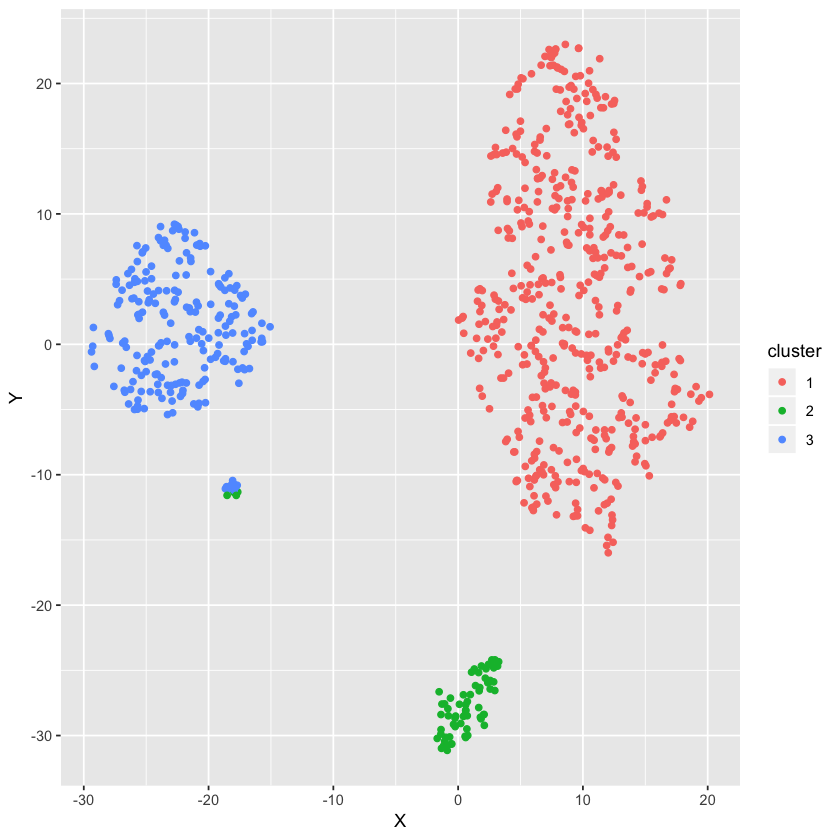

In [15]:
tsne_obj <- Rtsne(gower_dist, is_distance = TRUE)

tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(pam_fit$clustering),
         name = college_clean$name)

ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster))

Visually we can detect 4 groups of metoids. However the smaller group is split between the Private/Elite cluster and the Public/Not Elite cluster.

In [16]:
tsne_data %>%
  filter(X > -20 & X < -15,
         Y > -15 & Y < -10) %>%
  left_join(college_clean, by = "name") %>%
  collect %>%
  .[["name"]]

[1] "College of William and Mary"                
 [2] "Georgia Institute of Technology"            
 [3] "SUNY at Binghamton"                         
 [4] "SUNY College at Geneseo"                    
 [5] "Trenton State College"                      
 [6] "University of California at Berkeley"       
 [7] "University of California at Irvine"         
 [8] "University of Florida"                      
 [9] "University of Illinois - Urbana"            
[10] "University of Michigan at Ann Arbor"        
[11] "University of Minnesota at Morris"          
[12] "University of North Carolina at Chapel Hill"
[13] "University of Virginia"

While not large enough to warrant an additional cluster according to silhouette width, these 13 schools certainly have characteristics distinct from the other three clusters.